In [1]:
import os
import random
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from collections import deque
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, accuracy_score, recall_score,
                             precision_score, f1_score, confusion_matrix)
from types import SimpleNamespace # To create a config object easily

In [2]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: []


In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity=50000, alpha=0.6, beta=0.4, beta_increment=0.001):
        """
        Prioritized Experience Replay Buffer
        
        Args:
            capacity: Maximum size of buffer
            alpha: How much prioritization to use (0 = no prioritization, 1 = full prioritization)
            beta: Importance sampling correction factor
            beta_increment: How much to increase beta over time
        """
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros(capacity, dtype=np.float32) + 1e-5  # Small value to avoid zero priority
        self.position = 0
        self.alpha = alpha
        self.beta = beta
        self.beta_increment = beta_increment
        self.max_priority = 1.0
    
    def add(self, state, action, reward, next_state, done):
        # Convert to numpy arrays
        state = np.array(state, dtype=np.float32)
        action = np.array(action, dtype=np.int32)
        reward = np.array(reward, dtype=np.float32)
        next_state = np.array(next_state, dtype=np.float32)
        done = np.array(done, dtype=np.float32)
        
        # Store experience
        experience = (state, action, reward, next_state, done)
        
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.position] = experience
        
        # New transitions get maximum priority
        self.priorities[self.position] = self.max_priority
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        # Cannot sample if buffer doesn't have enough experiences
        if len(self.buffer) < batch_size:
            return None
        
        # Calculate sampling probabilities
        priorities = self.priorities[:len(self.buffer)]
        probs = priorities ** self.alpha
        probs /= probs.sum()
        
        # Sample indices based on priorities
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        
        # Calculate importance sampling weights
        weights = (len(self.buffer) * probs[indices]) ** (-self.beta)
        weights /= weights.max()  # Normalize
        weights = np.array(weights, dtype=np.float32)
        
        # Increase beta - will approach 1 over time
        self.beta = min(1.0, self.beta + self.beta_increment)
        
        # Get samples
        samples = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states, dones = map(np.array, zip(*samples))
        
        return states, actions.reshape(-1), rewards.reshape(-1, 1), next_states, dones.reshape(-1, 1), indices, weights.reshape(-1, 1)
    
    def update_priorities(self, indices, td_errors):
        for idx, error in zip(indices, td_errors):
            self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values
            self.max_priority = max(self.max_priority, self.priorities[idx])
    
    def __len__(self):
        return len(self.buffer)

In [5]:
class DuelingDQN(tf.keras.Model):
    def __init__(self, input_dim, n_actions, hidden_units=[128, 64], dropout_rate=0.25):
        super().__init__()
        self.hidden_layers = []
        for units in hidden_units:
             self.hidden_layers.append(tf.keras.layers.Dense(units, activation='relu'))
        self.drop = tf.keras.layers.Dropout(dropout_rate)
        self.adv = tf.keras.layers.Dense(n_actions, name="advantage")
        self.val = tf.keras.layers.Dense(1, name="value")

    def call(self, x):
        for layer in self.hidden_layers:
             x = layer(x)
        x = self.drop(x)
        adv = self.adv(x)
        val = self.val(x)
        mean_adv = tf.reduce_mean(adv, axis=1, keepdims=True)
        q_values = val + (adv - mean_adv)
        return q_values

In [6]:
# ─── Agent ────────────────────────────────────────────────────────────────
class Agent:
    def __init__(self, state_dim, n_actions, rewards_lab, minority_classes, config):
        self.config = config
        self.n_actions = n_actions

        # Networks
        self.net = DuelingDQN(state_dim, n_actions, config.hidden_units, config.dropout_rate)
        self.target = DuelingDQN(state_dim, n_actions, config.hidden_units, config.dropout_rate)
        dummy_input = tf.random.normal((1, state_dim))
        _ = self.net(dummy_input)
        _ = self.target(dummy_input)
        self.target.set_weights(self.net.get_weights())

        self.optimizer = tf.keras.optimizers.Adam(config.lr)
        self.buffer = PrioritizedReplayBuffer(config.buffer_capacity)

        # RL Params
        self.gamma = config.gamma
        self.batch_size = config.batch_size
        
        self.train_step = 0 # Tracks training updates

        # Reward Shaping
        self.rewards_lab = rewards_lab
        self.minority = set(minority_classes)

        # Target Network Updates
        self.target_update_freq = config.target_update_freq
        self.target_soft_update_rate = config.target_soft_update_rate

    def select_action(self, state, training=True):
        if len(state.shape) == 1:
            state = state[np.newaxis, :]
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        q_values = self.net(state_tensor, training=False)
        return tf.argmax(q_values, axis=1).numpy()[0]


    def get_reward(self, label, action, current_ir=None):
        """
        Improved reward function with adaptive scaling based on curriculum stage
        
        Args:
            label: true class
            action: predicted class
            current_ir: current imbalance ratio in curriculum (optional)
        """
        label = int(label)
        action = int(action)
        
        # Base reward values
        majority_reward = 1.0  # For majority class (0)
        minority_reward = 5.0  # For minority class (1)
        
        # Additional scaling based on current curriculum stage
        if current_ir is not None:
            # Increase minority reward as imbalance increases
            minority_scale = min(3.0, 1.0 + (current_ir / 10.0))
            # Decrease majority reward as imbalance increases
            majority_scale = max(0.2, 1.0 - (current_ir / 25.0))
            
            minority_reward *= minority_scale
            majority_reward *= majority_scale
        
        # Calculate final reward
        if label == 1:  # Minority class
            reward = minority_reward if action == label else -minority_reward * 1.5  # Penalty for missing minority
        else:  # Majority class
            reward = majority_reward if action == label else -majority_reward
        
        # No done flag for classification
        done = False
        
        return reward, done


    def store_transition(self, s, a, r, s2, done):
        self.buffer.add(s, a, r, s2, done)

    @tf.function
    def _train_on_batch_tf(self, states, actions, rewards, next_states, dones, weights=None):
        actions = tf.cast(actions, tf.int32)
        rewards = tf.cast(rewards, tf.float32)
        dones = tf.cast(dones, tf.float32)
        
        # Double DQN: select actions using online network
        q_next_main = self.net(next_states)
        next_actions = tf.argmax(q_next_main, axis=1, output_type=tf.int32)
        
        # Then evaluate using target network
        q_next_target = self.target(next_states)
        indices = tf.stack([tf.range(tf.shape(actions)[0]), next_actions], axis=1)
        target_q_values = tf.gather_nd(q_next_target, indices)
        target_q_values = tf.expand_dims(target_q_values, axis=1)
        
        # Calculate TD target
        y = rewards + (1.0 - dones) * self.gamma * target_q_values
        
        with tf.GradientTape() as tape:
            q_main = self.net(states)
            action_indices = tf.stack([tf.range(tf.shape(actions)[0]), actions], axis=1)
            q_a = tf.gather_nd(q_main, action_indices)
            q_a = tf.expand_dims(q_a, axis=1)
            
            # Calculate TD errors for updating priorities
            td_errors = tf.abs(y - q_a)
            
            # Use Huber loss with importance sampling weights
            if weights is not None:
                loss = tf.reduce_mean(weights * tf.keras.losses.Huber()(y, q_a))
            else:
                loss = tf.keras.losses.Huber()(y, q_a)
    
        grads = tape.gradient(loss, self.net.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.net.trainable_variables))
        
        return loss, td_errors

    def update_if_ready(self):
        if len(self.buffer) < self.batch_size:
            return None
            
        # Sample batch with priorities
        states, actions, rewards, next_states, dones, indices, weights = self.buffer.sample(self.batch_size)
        
        if states is None:  # Handle case where buffer doesn't have enough experiences
            return None
            
        # Convert to tensors
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.int32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)
        weights = tf.convert_to_tensor(weights, dtype=tf.float32)  # Importance sampling weights
        
        # Call TF function but with weights
        loss, td_errors = self._train_on_batch_tf(states, actions, rewards, next_states, dones, weights)
        
        # Update priorities
        self.buffer.update_priorities(indices, td_errors.numpy())
        
        return loss.numpy()

    def update_target_network(self):
        tau = self.config.target_soft_update_rate
        main_weights = self.net.get_weights()
        target_weights = self.target.get_weights()
        new_target_weights = []
        for main_w, target_w in zip(main_weights, target_weights):
            new_w = (1.0 - tau) * target_w + tau * main_w
            new_target_weights.append(new_w)
        self.target.set_weights(new_target_weights)

    def run_evaluation(self, X_eval, y_eval):
        preds = []
        for i in range(len(X_eval)):
            state = X_eval[i]
            action = self.select_action(state, training=False)
            preds.append(action)

        acc = accuracy_score(y_eval, preds)
        recall = recall_score(y_eval, preds, pos_label=1, zero_division=0)
        specificity = recall_score(y_eval, preds, pos_label=0, zero_division=0)
        precision = precision_score(y_eval, preds, pos_label=1, zero_division=0)
        f1 = f1_score(y_eval, preds, pos_label=1, zero_division=0)
        gmean = np.sqrt(recall * specificity) if recall > 0 and specificity > 0 else 0 # Handle sqrt(0)

        print(f" Eval Metrics -> Acc: {acc:.4f}, Recall (1): {recall:.4f}, Spec (0): {specificity:.4f}, Prec (1): {precision:.4f}, F1 (1): {f1:.4f}, G-Mean: {gmean:.4f}")
        return {'accuracy': acc, 'recall': recall, 'specificity': specificity, 'precision': precision, 'f1_score': f1, 'g_mean': gmean}

    def save(self, path, step):
        model_dir = os.path.join(path, f"step_{step}")
        os.makedirs(model_dir, exist_ok=True)
        self.net.save_weights(os.path.join(model_dir, 'qimb_weights.weights.h5'))
        self.target.save_weights(os.path.join(model_dir, 'qimb_target.weights.h5'))
        print(f"Model weights saved at step {step} to {model_dir}")

    def load(self, path, step):
        model_dir = os.path.join(path, f"step_{step}")
        weights_path = os.path.join(model_dir, 'qimb_weights.weights.h5')
        target_weights_path = os.path.join(model_dir, 'qimb_target.weights.h5')
        if os.path.exists(weights_path) and os.path.exists(target_weights_path):
            self.net.load_weights(weights_path)
            self.target.load_weights(target_weights_path)
            print(f"Model weights loaded from step {step} from {model_dir}")
        else:
            print(f"Weight files (.weights.h5) not found at {model_dir}")

In [7]:
def get_sample_index_for_curriculum(minority_indices, majority_indices, target_ir, step_in_stage=0, total_stage_steps=1):
    """
    Enhanced curriculum sampling with focus on minority class and curriculum progression
    
    Args:
        minority_indices: Indices of minority class samples
        majority_indices: Indices of majority class samples
        target_ir: Target imbalance ratio for current stage
        step_in_stage: Current step within this curriculum stage
        total_stage_steps: Total steps for this stage
    """
    # Calculate progress through stage (0 to 1)
    progress = min(1.0, step_in_stage / total_stage_steps)
    
    # Calculate effective IR based on progress (gradually increase to target)
    start_ir = max(1.0, target_ir * 0.5)  # Start with easier ratio
    effective_ir = start_ir + progress * (target_ir - start_ir)
    
    # Minority class focus increases as IR increases
    # Higher IR means we need more focus on minority class
    minority_focus = min(0.7, 0.3 + (target_ir / 20))
    
    # With probability (minority_focus), always pick minority
    if random.random() < minority_focus:
        return random.choice(minority_indices)
    else:
        # Otherwise sample based on effective IR
        prob_minority = 1.0 / (effective_ir + 1.0)
        if random.random() < prob_minority:
            return random.choice(minority_indices)
        else:
            return random.choice(majority_indices)

In [8]:
def dynamic_curriculum_controller(agent, X_val, y_val, current_ir, 
                                  min_steps_in_stage=5000, patience=3):
    """
    Determines if it's time to advance to the next curriculum stage
    
    Args:
        agent: The RL agent
        X_val: Validation features
        y_val: Validation labels
        current_ir: Current imbalance ratio
        min_steps_in_stage: Minimum steps before considering advancement
        patience: How many evaluations to wait for improvement
        
    Returns:
        should_advance: Boolean indicating whether to advance to next stage
    """
    # Initialize tracking variables if they don't exist
    if not hasattr(dynamic_curriculum_controller, "history"):
        dynamic_curriculum_controller.history = []
        dynamic_curriculum_controller.best_gmean = 0
        dynamic_curriculum_controller.steps_without_improvement = 0
        dynamic_curriculum_controller.steps_in_stage = 0
    
    # Get current validation metrics
    val_metrics = agent.run_evaluation(X_val, y_val)
    current_gmean = val_metrics['g_mean']
    
    # Record history and increment step counter
    dynamic_curriculum_controller.history.append(current_gmean)
    dynamic_curriculum_controller.steps_in_stage += 1
    
    # Check if we have a new best G-mean
    if current_gmean > dynamic_curriculum_controller.best_gmean + 0.01:  # 1% improvement threshold
        dynamic_curriculum_controller.best_gmean = current_gmean
        dynamic_curriculum_controller.steps_without_improvement = 0
        print(f"New best G-mean: {current_gmean:.4f} at IR={current_ir}")
    else:
        dynamic_curriculum_controller.steps_without_improvement += 1
    
    # Decide if we should advance to the next stage
    should_advance = False
    
    # Only consider advancing if minimum steps have been completed
    if dynamic_curriculum_controller.steps_in_stage >= min_steps_in_stage:
        # Case 1: Performance plateaued for 'patience' evaluations
        if dynamic_curriculum_controller.steps_without_improvement >= patience:
            should_advance = True
            print(f"Advancing due to performance plateau after {dynamic_curriculum_controller.steps_in_stage} steps")
        
        # Case 2: Very good performance (over 0.85 G-mean) - no need to stay at this level
        elif current_gmean > 0.85:
            should_advance = True
            print(f"Advancing due to excellent performance (G-mean={current_gmean:.4f})")
    
    # If advancing, reset counters for next stage
    if should_advance:
        dynamic_curriculum_controller.steps_without_improvement = 0
        dynamic_curriculum_controller.steps_in_stage = 0
        # Keep the best_gmean value across stages
    
    return should_advance

In [9]:
print("\n--- Setting Configuration ---")
config = SimpleNamespace(
    # Training Params
    # training_steps=350000, # Reduced for quicker demonstration, tune higher (e.g., 100k-500k)
    seed=42,


    curriculum_stages = [
        (1,  20000),
        (3,  30000),    # boosted
        (5,  30000),    # boosted
        (7,  30000),    # trimmed to peak
        (9,  25000),
        (11, 25000),
        (13, 25000),
        (15, 25000),
        (17, 35000),
        (19, 35000),
    ],

    # DRL Params
    gamma=0.99,
    lr=0.00005, # Initial learning rate - TUNE THIS
    batch_size=64,
    buffer_capacity=50000,

    # Network Params
    hidden_units=[128, 64], # TUNE THIS
    dropout_rate=0.25, # TUNE THIS

    # Target Network Update Params
    target_update_freq=500, # TUNE THIS
    target_soft_update_rate=0.01, # TUNE THIS

    # Reward Params
    minority_classes={1}, # Stroke is label 1

    # Evaluation/Saving Params
    eval_freq=5000,
    save_freq=20000,
    model_save_path='./curriculum_model_checkpoints/',
    results_save_path='./curriculum_results/',
)

config.training_steps = sum(updates for _, updates in config.curriculum_stages)


--- Setting Configuration ---


In [10]:
# Set seeds again just before training
random.seed(config.seed)
np.random.seed(config.seed)
tf.random.set_seed(config.seed)

# Create directories
os.makedirs(config.model_save_path, exist_ok=True)
os.makedirs(config.results_save_path, exist_ok=True)

print("Configuration set.")

Configuration set.


In [11]:
print("\n--- Preparing for Curriculum Training ---")
# Load data (assuming it was saved correctly in Step 4)
try:
    data_split_path = './'
    (X_train_np, y_train_np) = joblib.load(os.path.join(data_split_path,'train_data.pkl'))
    (X_val_np, y_val_np) = joblib.load(os.path.join(data_split_path,'val_data.pkl'))
    (X_test_np, y_test_np) = joblib.load(os.path.join(data_split_path,'test_data.pkl'))
    if isinstance(X_train_np, pd.DataFrame):
        X_train_np = X_train_np.values
        X_val_np = X_val_np.values
        X_test_np = X_test_np.values
    if isinstance(y_train_np, pd.Series):
        y_train_np = y_train_np.values
        y_val_np = y_val_np.values
        y_test_np = y_test_np.values
    print("Training/Validation/Test data loaded.")
except FileNotFoundError:
    print("Error: Preprocessed data files not found in ./preprocessed_data/. Cannot proceed.")
    exit()


--- Preparing for Curriculum Training ---
Training/Validation/Test data loaded.


In [12]:
# Prepare indices for curriculum sampling
minority_indices = np.where(y_train_np == 1)[0]
majority_indices = np.where(y_train_np == 0)[0]

if len(minority_indices) == 0 or len(majority_indices) == 0:
    print("Error: Training data lacks either minority or majority samples!")
    exit()

# Prepare Agent (using FINAL imbalance ratio for rewards)
state_dim = X_train_np.shape[1]
n_actions = 2
counts = np.bincount(y_train_np.astype(int))
minority_count = counts[1]
majority_count = counts[0]
final_imbalance_ratio_rho = minority_count / majority_count if majority_count > 0 else 1.0
rewards_lab = {0: final_imbalance_ratio_rho, 1: 1.0}

agent = Agent(state_dim, n_actions, rewards_lab, config.minority_classes, config)
print("Agent initialized.")

Agent initialized.


In [13]:
# --- Curriculum Training Loop (Corrected) ---
print(f"\nStarting Curriculum Training for approx {config.training_steps} update steps...")
start_time = time.time()

# Lists to store metrics
step_losses = []
step_rewards = []
validation_history = []
best_val_gmean = -1.0
training_steps_done = 0
interaction_steps = 0
training_complete = False # Flag to signal completion

try:
    # --- Curriculum Training with Dynamic Progression ---
    stage_idx = 0
    current_ir, max_steps_this_stage = config.curriculum_stages[stage_idx]
    steps_in_this_stage = 0
    
    print(f"\n--- Starting Curriculum Training with Dynamic Progression ---")
    print(f"Beginning with Stage 1: Target IR = {current_ir}, Max Steps = {max_steps_this_stage}")
    
    
    while not training_complete:
        # DYNAMIC SAMPLING: Get indices based on current curriculum stage
        idx = get_sample_index_for_curriculum(minority_indices, majority_indices, 
                                             current_ir, steps_in_this_stage, 
                                             max_steps_this_stage)
        idx2 = get_sample_index_for_curriculum(minority_indices, majority_indices, 
                                              current_ir, steps_in_this_stage, 
                                              max_steps_this_stage)
        
        # Get states and label
        s = X_train_np[idx]
        y = y_train_np[idx]
        s2 = X_train_np[idx2]
        
        # Select action
        a = agent.select_action(s, training=True)
        
        # Get reward with current IR context
        r, done = agent.get_reward(int(y), int(a), current_ir)
        step_rewards.append(r)
        
        # Store transition
        agent.store_transition(s, a, r, s2, done)
        
        interaction_steps += 1
        
        # --- Perform Gradient Update if Buffer Ready ---
        loss = agent.update_if_ready()
        if loss is not None:
            step_losses.append(loss)
            training_steps_done += 1
            steps_in_this_stage += 1
            agent.train_step = training_steps_done
            
            # Update target network periodically
            if training_steps_done % config.target_update_freq == 0:
                agent.update_target_network()
            
            
            # Periodic evaluation
            if training_steps_done % config.eval_freq == 0:
                eval_start_time = time.time()
                print(f"\n--- Training Step {training_steps_done} (Stage {stage_idx+1}, IR={current_ir}) ---")
                
                # Run validation
                val_metrics = agent.run_evaluation(X_val_np, y_val_np)
                val_metrics['step'] = training_steps_done
                val_metrics['stage'] = stage_idx + 1
                val_metrics['target_ir'] = current_ir
                validation_history.append(val_metrics)
                
                # Check best model
                current_val_gmean = val_metrics.get('g_mean', -1.0)
                if current_val_gmean > best_val_gmean:
                    print(f"New best validation G-Mean: {current_val_gmean:.4f} (previous: {best_val_gmean:.4f})")
                    best_val_gmean = current_val_gmean
                    agent.save(config.model_save_path, 'best')
                
                # DYNAMIC CURRICULUM: Check if we should advance to next stage
                should_advance = dynamic_curriculum_controller(
                    agent, X_val_np, y_val_np, current_ir)
                
                if should_advance and stage_idx < len(config.curriculum_stages) - 1:
                    # Save current stage model
                    agent.save(config.model_save_path, f'stage_{stage_idx+1}')
                    
                    # Move to next stage
                    stage_idx += 1
                    current_ir, max_steps_this_stage = config.curriculum_stages[stage_idx]
                    steps_in_this_stage = 0
                    
                    print(f"\n=== Advancing to Stage {stage_idx+1}: Target IR = {current_ir} ===")
            
            # Periodic model saving
            if training_steps_done % config.save_freq == 0:
                agent.save(config.model_save_path, training_steps_done)
            
            # Check if we've hit stage limit or total limit
            if steps_in_this_stage >= max_steps_this_stage:
                if stage_idx < len(config.curriculum_stages) - 1:
                    # Save current stage model
                    agent.save(config.model_save_path, f'stage_{stage_idx+1}')
                    
                    # Move to next stage
                    stage_idx += 1
                    current_ir, max_steps_this_stage = config.curriculum_stages[stage_idx]
                    steps_in_this_stage = 0
                    
                    print(f"\n=== Advancing to Stage {stage_idx+1}: Target IR = {current_ir} ===")
                else:
                    print("\nCompleted all curriculum stages.")
                    training_complete = True
            
            # Check if we've reached total training steps
            if training_steps_done >= config.training_steps:
                print("\nReached total training steps limit.")
                training_complete = True

except KeyboardInterrupt:
    print("\nTraining interrupted by user.")
except Exception as e:
    print(f"\nAn error occurred during training: {e}")
    import traceback
    traceback.print_exc()

# --- End of Training Loop ---
training_duration = time.time() - start_time
print(f"\nCurriculum Training Finished (or interrupted) in {training_duration:.2f} seconds after {training_steps_done} update steps.")


Starting Curriculum Training for approx 280000 update steps...

--- Starting Curriculum Training with Dynamic Progression ---
Beginning with Stage 1: Target IR = 1, Max Steps = 20000


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 5000 (Stage 1, IR=1) ---
 Eval Metrics -> Acc: 0.4582, Recall (1): 0.9459, Spec (0): 0.4335, Prec (1): 0.0781, F1 (1): 0.1443, G-Mean: 0.6403
New best validation G-Mean: 0.6403 (previous: -1.0000)
Model weights saved at step best to ./curriculum_model_checkpoints/step_best
 Eval Metrics -> Acc: 0.4582, Recall (1): 0.9459, Spec (0): 0.4335, Prec (1): 0.0781, F1 (1): 0.1443, G-Mean: 0.6403
New best G-mean: 0.6403 at IR=1


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 10000 (Stage 1, IR=1) ---
 Eval Metrics -> Acc: 0.4987, Recall (1): 0.9459, Spec (0): 0.4760, Prec (1): 0.0839, F1 (1): 0.1542, G-Mean: 0.6710
New best validation G-Mean: 0.6710 (previous: 0.6403)
Model weights saved at step best to ./curriculum_model_checkpoints/step_best
 Eval Metrics -> Acc: 0.4987, Recall (1): 0.9459, Spec (0): 0.4760, Prec (1): 0.0839, F1 (1): 0.1542, G-Mean: 0.6710
New best G-mean: 0.6710 at IR=1


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 15000 (Stage 1, IR=1) ---
 Eval Metrics -> Acc: 0.5457, Recall (1): 0.8649, Spec (0): 0.5295, Prec (1): 0.0853, F1 (1): 0.1553, G-Mean: 0.6767
New best validation G-Mean: 0.6767 (previous: 0.6710)
Model weights saved at step best to ./curriculum_model_checkpoints/step_best
 Eval Metrics -> Acc: 0.5457, Recall (1): 0.8649, Spec (0): 0.5295, Prec (1): 0.0853, F1 (1): 0.1553, G-Mean: 0.6767


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 20000 (Stage 1, IR=1) ---
 Eval Metrics -> Acc: 0.6018, Recall (1): 0.8649, Spec (0): 0.5885, Prec (1): 0.0964, F1 (1): 0.1734, G-Mean: 0.7134
New best validation G-Mean: 0.7134 (previous: 0.6767)
Model weights saved at step best to ./curriculum_model_checkpoints/step_best
 Eval Metrics -> Acc: 0.6018, Recall (1): 0.8649, Spec (0): 0.5885, Prec (1): 0.0964, F1 (1): 0.1734, G-Mean: 0.7134
New best G-mean: 0.7134 at IR=1
Model weights saved at step 20000 to ./curriculum_model_checkpoints/step_20000
Model weights saved at step stage_1 to ./curriculum_model_checkpoints/step_stage_1

=== Advancing to Stage 2: Target IR = 3 ===


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 25000 (Stage 2, IR=3) ---
 Eval Metrics -> Acc: 0.6279, Recall (1): 0.8649, Spec (0): 0.6159, Prec (1): 0.1026, F1 (1): 0.1834, G-Mean: 0.7298
New best validation G-Mean: 0.7298 (previous: 0.7134)
Model weights saved at step best to ./curriculum_model_checkpoints/step_best
 Eval Metrics -> Acc: 0.6279, Recall (1): 0.8649, Spec (0): 0.6159, Prec (1): 0.1026, F1 (1): 0.1834, G-Mean: 0.7298
New best G-mean: 0.7298 at IR=3


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 30000 (Stage 2, IR=3) ---
 Eval Metrics -> Acc: 0.6554, Recall (1): 0.8108, Spec (0): 0.6475, Prec (1): 0.1045, F1 (1): 0.1852, G-Mean: 0.7245
 Eval Metrics -> Acc: 0.6554, Recall (1): 0.8108, Spec (0): 0.6475, Prec (1): 0.1045, F1 (1): 0.1852, G-Mean: 0.7245


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 35000 (Stage 2, IR=3) ---
 Eval Metrics -> Acc: 0.6880, Recall (1): 0.7838, Spec (0): 0.6831, Prec (1): 0.1115, F1 (1): 0.1953, G-Mean: 0.7317
New best validation G-Mean: 0.7317 (previous: 0.7298)
Model weights saved at step best to ./curriculum_model_checkpoints/step_best
 Eval Metrics -> Acc: 0.6880, Recall (1): 0.7838, Spec (0): 0.6831, Prec (1): 0.1115, F1 (1): 0.1953, G-Mean: 0.7317


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 40000 (Stage 2, IR=3) ---
 Eval Metrics -> Acc: 0.7089, Recall (1): 0.7568, Spec (0): 0.7064, Prec (1): 0.1157, F1 (1): 0.2007, G-Mean: 0.7312
 Eval Metrics -> Acc: 0.7089, Recall (1): 0.7568, Spec (0): 0.7064, Prec (1): 0.1157, F1 (1): 0.2007, G-Mean: 0.7312
Model weights saved at step 40000 to ./curriculum_model_checkpoints/step_40000


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 45000 (Stage 2, IR=3) ---
 Eval Metrics -> Acc: 0.7232, Recall (1): 0.7297, Spec (0): 0.7229, Prec (1): 0.1179, F1 (1): 0.2030, G-Mean: 0.7263
 Eval Metrics -> Acc: 0.7232, Recall (1): 0.7297, Spec (0): 0.7229, Prec (1): 0.1179, F1 (1): 0.2030, G-Mean: 0.7263


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 50000 (Stage 2, IR=3) ---
 Eval Metrics -> Acc: 0.7428, Recall (1): 0.6486, Spec (0): 0.7476, Prec (1): 0.1154, F1 (1): 0.1959, G-Mean: 0.6964
 Eval Metrics -> Acc: 0.7428, Recall (1): 0.6486, Spec (0): 0.7476, Prec (1): 0.1154, F1 (1): 0.1959, G-Mean: 0.6964
Model weights saved at step stage_2 to ./curriculum_model_checkpoints/step_stage_2

=== Advancing to Stage 3: Target IR = 5 ===


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 55000 (Stage 3, IR=5) ---
 Eval Metrics -> Acc: 0.7311, Recall (1): 0.6757, Spec (0): 0.7339, Prec (1): 0.1142, F1 (1): 0.1953, G-Mean: 0.7042
 Eval Metrics -> Acc: 0.7311, Recall (1): 0.6757, Spec (0): 0.7339, Prec (1): 0.1142, F1 (1): 0.1953, G-Mean: 0.7042


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 60000 (Stage 3, IR=5) ---
 Eval Metrics -> Acc: 0.7480, Recall (1): 0.6757, Spec (0): 0.7517, Prec (1): 0.1214, F1 (1): 0.2058, G-Mean: 0.7127
 Eval Metrics -> Acc: 0.7480, Recall (1): 0.6757, Spec (0): 0.7517, Prec (1): 0.1214, F1 (1): 0.2058, G-Mean: 0.7127
Model weights saved at step 60000 to ./curriculum_model_checkpoints/step_60000


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 65000 (Stage 3, IR=5) ---
 Eval Metrics -> Acc: 0.7715, Recall (1): 0.5946, Spec (0): 0.7805, Prec (1): 0.1209, F1 (1): 0.2009, G-Mean: 0.6812
 Eval Metrics -> Acc: 0.7715, Recall (1): 0.5946, Spec (0): 0.7805, Prec (1): 0.1209, F1 (1): 0.2009, G-Mean: 0.6812


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 70000 (Stage 3, IR=5) ---
 Eval Metrics -> Acc: 0.7859, Recall (1): 0.5946, Spec (0): 0.7956, Prec (1): 0.1287, F1 (1): 0.2115, G-Mean: 0.6878
 Eval Metrics -> Acc: 0.7859, Recall (1): 0.5946, Spec (0): 0.7956, Prec (1): 0.1287, F1 (1): 0.2115, G-Mean: 0.6878


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 75000 (Stage 3, IR=5) ---
 Eval Metrics -> Acc: 0.7898, Recall (1): 0.5405, Spec (0): 0.8025, Prec (1): 0.1220, F1 (1): 0.1990, G-Mean: 0.6586
 Eval Metrics -> Acc: 0.7898, Recall (1): 0.5405, Spec (0): 0.8025, Prec (1): 0.1220, F1 (1): 0.1990, G-Mean: 0.6586


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 80000 (Stage 3, IR=5) ---
 Eval Metrics -> Acc: 0.7990, Recall (1): 0.5405, Spec (0): 0.8121, Prec (1): 0.1274, F1 (1): 0.2062, G-Mean: 0.6625
 Eval Metrics -> Acc: 0.7990, Recall (1): 0.5405, Spec (0): 0.8121, Prec (1): 0.1274, F1 (1): 0.2062, G-Mean: 0.6625
Model weights saved at step 80000 to ./curriculum_model_checkpoints/step_80000
Model weights saved at step stage_3 to ./curriculum_model_checkpoints/step_stage_3

=== Advancing to Stage 4: Target IR = 7 ===


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 85000 (Stage 4, IR=7) ---
 Eval Metrics -> Acc: 0.8029, Recall (1): 0.5676, Spec (0): 0.8148, Prec (1): 0.1346, F1 (1): 0.2176, G-Mean: 0.6800
 Eval Metrics -> Acc: 0.8029, Recall (1): 0.5676, Spec (0): 0.8148, Prec (1): 0.1346, F1 (1): 0.2176, G-Mean: 0.6800


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 90000 (Stage 4, IR=7) ---
 Eval Metrics -> Acc: 0.8159, Recall (1): 0.4865, Spec (0): 0.8326, Prec (1): 0.1286, F1 (1): 0.2034, G-Mean: 0.6365
 Eval Metrics -> Acc: 0.8159, Recall (1): 0.4865, Spec (0): 0.8326, Prec (1): 0.1286, F1 (1): 0.2034, G-Mean: 0.6365


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 95000 (Stage 4, IR=7) ---
 Eval Metrics -> Acc: 0.8159, Recall (1): 0.5135, Spec (0): 0.8313, Prec (1): 0.1338, F1 (1): 0.2123, G-Mean: 0.6534
 Eval Metrics -> Acc: 0.8159, Recall (1): 0.5135, Spec (0): 0.8313, Prec (1): 0.1338, F1 (1): 0.2123, G-Mean: 0.6534


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 100000 (Stage 4, IR=7) ---
 Eval Metrics -> Acc: 0.8094, Recall (1): 0.5135, Spec (0): 0.8244, Prec (1): 0.1293, F1 (1): 0.2065, G-Mean: 0.6507
 Eval Metrics -> Acc: 0.8094, Recall (1): 0.5135, Spec (0): 0.8244, Prec (1): 0.1293, F1 (1): 0.2065, G-Mean: 0.6507
Model weights saved at step 100000 to ./curriculum_model_checkpoints/step_100000


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 105000 (Stage 4, IR=7) ---
 Eval Metrics -> Acc: 0.8185, Recall (1): 0.4595, Spec (0): 0.8368, Prec (1): 0.1250, F1 (1): 0.1965, G-Mean: 0.6200
 Eval Metrics -> Acc: 0.8185, Recall (1): 0.4595, Spec (0): 0.8368, Prec (1): 0.1250, F1 (1): 0.1965, G-Mean: 0.6200


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 110000 (Stage 4, IR=7) ---
 Eval Metrics -> Acc: 0.8185, Recall (1): 0.3784, Spec (0): 0.8409, Prec (1): 0.1077, F1 (1): 0.1677, G-Mean: 0.5641
 Eval Metrics -> Acc: 0.8185, Recall (1): 0.3784, Spec (0): 0.8409, Prec (1): 0.1077, F1 (1): 0.1677, G-Mean: 0.5641
Model weights saved at step stage_4 to ./curriculum_model_checkpoints/step_stage_4

=== Advancing to Stage 5: Target IR = 9 ===


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 115000 (Stage 5, IR=9) ---
 Eval Metrics -> Acc: 0.8225, Recall (1): 0.3514, Spec (0): 0.8464, Prec (1): 0.1040, F1 (1): 0.1605, G-Mean: 0.5453
 Eval Metrics -> Acc: 0.8225, Recall (1): 0.3514, Spec (0): 0.8464, Prec (1): 0.1040, F1 (1): 0.1605, G-Mean: 0.5453


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 120000 (Stage 5, IR=9) ---
 Eval Metrics -> Acc: 0.8238, Recall (1): 0.3243, Spec (0): 0.8491, Prec (1): 0.0984, F1 (1): 0.1509, G-Mean: 0.5248
 Eval Metrics -> Acc: 0.8238, Recall (1): 0.3243, Spec (0): 0.8491, Prec (1): 0.0984, F1 (1): 0.1509, G-Mean: 0.5248
Model weights saved at step 120000 to ./curriculum_model_checkpoints/step_120000


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 125000 (Stage 5, IR=9) ---
 Eval Metrics -> Acc: 0.8094, Recall (1): 0.4324, Spec (0): 0.8285, Prec (1): 0.1135, F1 (1): 0.1798, G-Mean: 0.5986
 Eval Metrics -> Acc: 0.8094, Recall (1): 0.4324, Spec (0): 0.8285, Prec (1): 0.1135, F1 (1): 0.1798, G-Mean: 0.5986


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 130000 (Stage 5, IR=9) ---
 Eval Metrics -> Acc: 0.8185, Recall (1): 0.3784, Spec (0): 0.8409, Prec (1): 0.1077, F1 (1): 0.1677, G-Mean: 0.5641
 Eval Metrics -> Acc: 0.8185, Recall (1): 0.3784, Spec (0): 0.8409, Prec (1): 0.1077, F1 (1): 0.1677, G-Mean: 0.5641


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 135000 (Stage 5, IR=9) ---
 Eval Metrics -> Acc: 0.8068, Recall (1): 0.4324, Spec (0): 0.8258, Prec (1): 0.1119, F1 (1): 0.1778, G-Mean: 0.5976
 Eval Metrics -> Acc: 0.8068, Recall (1): 0.4324, Spec (0): 0.8258, Prec (1): 0.1119, F1 (1): 0.1778, G-Mean: 0.5976
Model weights saved at step stage_5 to ./curriculum_model_checkpoints/step_stage_5

=== Advancing to Stage 6: Target IR = 11 ===


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 140000 (Stage 6, IR=11) ---
 Eval Metrics -> Acc: 0.8146, Recall (1): 0.4595, Spec (0): 0.8326, Prec (1): 0.1223, F1 (1): 0.1932, G-Mean: 0.6185
 Eval Metrics -> Acc: 0.8146, Recall (1): 0.4595, Spec (0): 0.8326, Prec (1): 0.1223, F1 (1): 0.1932, G-Mean: 0.6185
Model weights saved at step 140000 to ./curriculum_model_checkpoints/step_140000


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 145000 (Stage 6, IR=11) ---
 Eval Metrics -> Acc: 0.8094, Recall (1): 0.4595, Spec (0): 0.8272, Prec (1): 0.1189, F1 (1): 0.1889, G-Mean: 0.6165
 Eval Metrics -> Acc: 0.8094, Recall (1): 0.4595, Spec (0): 0.8272, Prec (1): 0.1189, F1 (1): 0.1889, G-Mean: 0.6165


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 150000 (Stage 6, IR=11) ---
 Eval Metrics -> Acc: 0.8068, Recall (1): 0.4324, Spec (0): 0.8258, Prec (1): 0.1119, F1 (1): 0.1778, G-Mean: 0.5976
 Eval Metrics -> Acc: 0.8068, Recall (1): 0.4324, Spec (0): 0.8258, Prec (1): 0.1119, F1 (1): 0.1778, G-Mean: 0.5976


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 155000 (Stage 6, IR=11) ---
 Eval Metrics -> Acc: 0.8081, Recall (1): 0.4324, Spec (0): 0.8272, Prec (1): 0.1127, F1 (1): 0.1788, G-Mean: 0.5981
 Eval Metrics -> Acc: 0.8081, Recall (1): 0.4324, Spec (0): 0.8272, Prec (1): 0.1127, F1 (1): 0.1788, G-Mean: 0.5981


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 160000 (Stage 6, IR=11) ---
 Eval Metrics -> Acc: 0.8159, Recall (1): 0.4595, Spec (0): 0.8340, Prec (1): 0.1232, F1 (1): 0.1943, G-Mean: 0.6190
 Eval Metrics -> Acc: 0.8159, Recall (1): 0.4595, Spec (0): 0.8340, Prec (1): 0.1232, F1 (1): 0.1943, G-Mean: 0.6190
Model weights saved at step 160000 to ./curriculum_model_checkpoints/step_160000
Model weights saved at step stage_6 to ./curriculum_model_checkpoints/step_stage_6

=== Advancing to Stage 7: Target IR = 13 ===


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 165000 (Stage 7, IR=13) ---
 Eval Metrics -> Acc: 0.8251, Recall (1): 0.3514, Spec (0): 0.8491, Prec (1): 0.1057, F1 (1): 0.1625, G-Mean: 0.5462
 Eval Metrics -> Acc: 0.8251, Recall (1): 0.3514, Spec (0): 0.8491, Prec (1): 0.1057, F1 (1): 0.1625, G-Mean: 0.5462


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 170000 (Stage 7, IR=13) ---
 Eval Metrics -> Acc: 0.8225, Recall (1): 0.4054, Spec (0): 0.8436, Prec (1): 0.1163, F1 (1): 0.1807, G-Mean: 0.5848
 Eval Metrics -> Acc: 0.8225, Recall (1): 0.4054, Spec (0): 0.8436, Prec (1): 0.1163, F1 (1): 0.1807, G-Mean: 0.5848


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 175000 (Stage 7, IR=13) ---
 Eval Metrics -> Acc: 0.8133, Recall (1): 0.4324, Spec (0): 0.8326, Prec (1): 0.1159, F1 (1): 0.1829, G-Mean: 0.6001
 Eval Metrics -> Acc: 0.8133, Recall (1): 0.4324, Spec (0): 0.8326, Prec (1): 0.1159, F1 (1): 0.1829, G-Mean: 0.6001


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 180000 (Stage 7, IR=13) ---
 Eval Metrics -> Acc: 0.8277, Recall (1): 0.4324, Spec (0): 0.8477, Prec (1): 0.1260, F1 (1): 0.1951, G-Mean: 0.6055
 Eval Metrics -> Acc: 0.8277, Recall (1): 0.4324, Spec (0): 0.8477, Prec (1): 0.1260, F1 (1): 0.1951, G-Mean: 0.6055
Model weights saved at step 180000 to ./curriculum_model_checkpoints/step_180000


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 185000 (Stage 7, IR=13) ---
 Eval Metrics -> Acc: 0.8133, Recall (1): 0.4595, Spec (0): 0.8313, Prec (1): 0.1214, F1 (1): 0.1921, G-Mean: 0.6180
 Eval Metrics -> Acc: 0.8133, Recall (1): 0.4595, Spec (0): 0.8313, Prec (1): 0.1214, F1 (1): 0.1921, G-Mean: 0.6180
Model weights saved at step stage_7 to ./curriculum_model_checkpoints/step_stage_7

=== Advancing to Stage 8: Target IR = 15 ===


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 190000 (Stage 8, IR=15) ---
 Eval Metrics -> Acc: 0.8355, Recall (1): 0.3784, Spec (0): 0.8587, Prec (1): 0.1197, F1 (1): 0.1818, G-Mean: 0.5700
 Eval Metrics -> Acc: 0.8355, Recall (1): 0.3784, Spec (0): 0.8587, Prec (1): 0.1197, F1 (1): 0.1818, G-Mean: 0.5700


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 195000 (Stage 8, IR=15) ---
 Eval Metrics -> Acc: 0.8355, Recall (1): 0.3514, Spec (0): 0.8601, Prec (1): 0.1130, F1 (1): 0.1711, G-Mean: 0.5497
 Eval Metrics -> Acc: 0.8355, Recall (1): 0.3514, Spec (0): 0.8601, Prec (1): 0.1130, F1 (1): 0.1711, G-Mean: 0.5497


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 200000 (Stage 8, IR=15) ---
 Eval Metrics -> Acc: 0.8342, Recall (1): 0.3514, Spec (0): 0.8587, Prec (1): 0.1121, F1 (1): 0.1699, G-Mean: 0.5493
 Eval Metrics -> Acc: 0.8342, Recall (1): 0.3514, Spec (0): 0.8587, Prec (1): 0.1121, F1 (1): 0.1699, G-Mean: 0.5493
Model weights saved at step 200000 to ./curriculum_model_checkpoints/step_200000


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 205000 (Stage 8, IR=15) ---
 Eval Metrics -> Acc: 0.8159, Recall (1): 0.4865, Spec (0): 0.8326, Prec (1): 0.1286, F1 (1): 0.2034, G-Mean: 0.6365
 Eval Metrics -> Acc: 0.8159, Recall (1): 0.4865, Spec (0): 0.8326, Prec (1): 0.1286, F1 (1): 0.2034, G-Mean: 0.6365


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 210000 (Stage 8, IR=15) ---
 Eval Metrics -> Acc: 0.8159, Recall (1): 0.3784, Spec (0): 0.8381, Prec (1): 0.1061, F1 (1): 0.1657, G-Mean: 0.5631
 Eval Metrics -> Acc: 0.8159, Recall (1): 0.3784, Spec (0): 0.8381, Prec (1): 0.1061, F1 (1): 0.1657, G-Mean: 0.5631
Model weights saved at step stage_8 to ./curriculum_model_checkpoints/step_stage_8

=== Advancing to Stage 9: Target IR = 17 ===


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 215000 (Stage 9, IR=17) ---
 Eval Metrics -> Acc: 0.8159, Recall (1): 0.4865, Spec (0): 0.8326, Prec (1): 0.1286, F1 (1): 0.2034, G-Mean: 0.6365
 Eval Metrics -> Acc: 0.8159, Recall (1): 0.4865, Spec (0): 0.8326, Prec (1): 0.1286, F1 (1): 0.2034, G-Mean: 0.6365


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 220000 (Stage 9, IR=17) ---
 Eval Metrics -> Acc: 0.8198, Recall (1): 0.4324, Spec (0): 0.8395, Prec (1): 0.1203, F1 (1): 0.1882, G-Mean: 0.6025
 Eval Metrics -> Acc: 0.8198, Recall (1): 0.4324, Spec (0): 0.8395, Prec (1): 0.1203, F1 (1): 0.1882, G-Mean: 0.6025
Model weights saved at step 220000 to ./curriculum_model_checkpoints/step_220000


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 225000 (Stage 9, IR=17) ---
 Eval Metrics -> Acc: 0.8159, Recall (1): 0.4054, Spec (0): 0.8368, Prec (1): 0.1119, F1 (1): 0.1754, G-Mean: 0.5824
 Eval Metrics -> Acc: 0.8159, Recall (1): 0.4054, Spec (0): 0.8368, Prec (1): 0.1119, F1 (1): 0.1754, G-Mean: 0.5824


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 230000 (Stage 9, IR=17) ---
 Eval Metrics -> Acc: 0.8251, Recall (1): 0.3784, Spec (0): 0.8477, Prec (1): 0.1120, F1 (1): 0.1728, G-Mean: 0.5664
 Eval Metrics -> Acc: 0.8251, Recall (1): 0.3784, Spec (0): 0.8477, Prec (1): 0.1120, F1 (1): 0.1728, G-Mean: 0.5664


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 235000 (Stage 9, IR=17) ---
 Eval Metrics -> Acc: 0.8107, Recall (1): 0.4324, Spec (0): 0.8299, Prec (1): 0.1143, F1 (1): 0.1808, G-Mean: 0.5991
 Eval Metrics -> Acc: 0.8107, Recall (1): 0.4324, Spec (0): 0.8299, Prec (1): 0.1143, F1 (1): 0.1808, G-Mean: 0.5991


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 240000 (Stage 9, IR=17) ---
 Eval Metrics -> Acc: 0.8185, Recall (1): 0.4595, Spec (0): 0.8368, Prec (1): 0.1250, F1 (1): 0.1965, G-Mean: 0.6200
 Eval Metrics -> Acc: 0.8185, Recall (1): 0.4595, Spec (0): 0.8368, Prec (1): 0.1250, F1 (1): 0.1965, G-Mean: 0.6200
Model weights saved at step 240000 to ./curriculum_model_checkpoints/step_240000


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 245000 (Stage 9, IR=17) ---
 Eval Metrics -> Acc: 0.8211, Recall (1): 0.4865, Spec (0): 0.8381, Prec (1): 0.1324, F1 (1): 0.2081, G-Mean: 0.6385
 Eval Metrics -> Acc: 0.8211, Recall (1): 0.4865, Spec (0): 0.8381, Prec (1): 0.1324, F1 (1): 0.2081, G-Mean: 0.6385
Model weights saved at step stage_9 to ./curriculum_model_checkpoints/step_stage_9

=== Advancing to Stage 10: Target IR = 19 ===


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 250000 (Stage 10, IR=19) ---
 Eval Metrics -> Acc: 0.8120, Recall (1): 0.5676, Spec (0): 0.8244, Prec (1): 0.1409, F1 (1): 0.2258, G-Mean: 0.6840
 Eval Metrics -> Acc: 0.8120, Recall (1): 0.5676, Spec (0): 0.8244, Prec (1): 0.1409, F1 (1): 0.2258, G-Mean: 0.6840


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 255000 (Stage 10, IR=19) ---
 Eval Metrics -> Acc: 0.8185, Recall (1): 0.4324, Spec (0): 0.8381, Prec (1): 0.1194, F1 (1): 0.1871, G-Mean: 0.6020
 Eval Metrics -> Acc: 0.8185, Recall (1): 0.4324, Spec (0): 0.8381, Prec (1): 0.1194, F1 (1): 0.1871, G-Mean: 0.6020


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 260000 (Stage 10, IR=19) ---
 Eval Metrics -> Acc: 0.8159, Recall (1): 0.4324, Spec (0): 0.8354, Prec (1): 0.1176, F1 (1): 0.1850, G-Mean: 0.6010
 Eval Metrics -> Acc: 0.8159, Recall (1): 0.4324, Spec (0): 0.8354, Prec (1): 0.1176, F1 (1): 0.1850, G-Mean: 0.6010
Model weights saved at step 260000 to ./curriculum_model_checkpoints/step_260000


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 265000 (Stage 10, IR=19) ---
 Eval Metrics -> Acc: 0.8133, Recall (1): 0.4324, Spec (0): 0.8326, Prec (1): 0.1159, F1 (1): 0.1829, G-Mean: 0.6001
 Eval Metrics -> Acc: 0.8133, Recall (1): 0.4324, Spec (0): 0.8326, Prec (1): 0.1159, F1 (1): 0.1829, G-Mean: 0.6001


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 270000 (Stage 10, IR=19) ---
 Eval Metrics -> Acc: 0.8081, Recall (1): 0.5135, Spec (0): 0.8230, Prec (1): 0.1284, F1 (1): 0.2054, G-Mean: 0.6501
 Eval Metrics -> Acc: 0.8081, Recall (1): 0.5135, Spec (0): 0.8230, Prec (1): 0.1284, F1 (1): 0.2054, G-Mean: 0.6501


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 275000 (Stage 10, IR=19) ---
 Eval Metrics -> Acc: 0.8381, Recall (1): 0.4054, Spec (0): 0.8601, Prec (1): 0.1282, F1 (1): 0.1948, G-Mean: 0.5905
 Eval Metrics -> Acc: 0.8381, Recall (1): 0.4054, Spec (0): 0.8601, Prec (1): 0.1282, F1 (1): 0.1948, G-Mean: 0.5905


C:\Users\hanan\AppData\Local\Temp\ipykernel_7452\3581279372.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = min(abs(error) + 1e-5, 100)  # Clipped to avoid extreme values



--- Training Step 280000 (Stage 10, IR=19) ---
 Eval Metrics -> Acc: 0.8107, Recall (1): 0.5135, Spec (0): 0.8258, Prec (1): 0.1301, F1 (1): 0.2077, G-Mean: 0.6512
 Eval Metrics -> Acc: 0.8107, Recall (1): 0.5135, Spec (0): 0.8258, Prec (1): 0.1301, F1 (1): 0.2077, G-Mean: 0.6512
Model weights saved at step 280000 to ./curriculum_model_checkpoints/step_280000

Completed all curriculum stages.

Reached total training steps limit.

Curriculum Training Finished (or interrupted) in 2272.00 seconds after 280000 update steps.


In [14]:
agent.save(config.model_save_path, 'final')

Model weights saved at step final to ./curriculum_model_checkpoints/step_final


In [15]:
# Save training history/metrics
try:
    loss_df = pd.DataFrame({'step': range(len(step_losses)), 'loss': step_losses})
    loss_df.to_csv(os.path.join(config.results_save_path, 'step_losses.csv'), index=False)

    rewards_df = pd.DataFrame({'step': range(len(step_rewards)), 'reward': step_rewards})
    rewards_df.to_csv(os.path.join(config.results_save_path, 'step_rewards.csv'), index=False)

    if validation_history:
        val_history_df = pd.DataFrame(validation_history)
        val_history_df.to_csv(os.path.join(config.results_save_path, 'validation_history.csv'), index=False)
    print("Training metrics saved.")
except Exception as e:
    print(f"Error saving training metrics: {e}")


Training metrics saved.


In [16]:
print("\n--- Final Test Set Evaluation (using 'final' model) ---")
test_metrics_final = agent.run_evaluation(X_test_np, y_test_np)
print("\nFinal Test Metrics (Final Model):", test_metrics_final)

print("\n--- Final Test Set Evaluation (using 'best' model based on validation G-Mean) ---")
try:
    agent.load(config.model_save_path, 'best') # Load the best saved weights
    test_metrics_best = agent.run_evaluation(X_test_np, y_test_np)
    print("\nFinal Test Metrics (Best Validation Model):", test_metrics_best)
except Exception as e:
    print(f"Could not load or evaluate 'best' model: {e}")


--- Final Test Set Evaluation (using 'final' model) ---
 Eval Metrics -> Acc: 0.8149, Recall (1): 0.4211, Spec (0): 0.8354, Prec (1): 0.1176, F1 (1): 0.1839, G-Mean: 0.5931

Final Test Metrics (Final Model): {'accuracy': 0.8148631029986962, 'recall': 0.42105263157894735, 'specificity': 0.8353909465020576, 'precision': 0.11764705882352941, 'f1_score': 0.1839080459770115, 'g_mean': 0.5930797218097403}

--- Final Test Set Evaluation (using 'best' model based on validation G-Mean) ---
Model weights loaded from step best from ./curriculum_model_checkpoints/step_best
 Eval Metrics -> Acc: 0.6858, Recall (1): 0.7895, Spec (0): 0.6804, Prec (1): 0.1141, F1 (1): 0.1993, G-Mean: 0.7329

Final Test Metrics (Best Validation Model): {'accuracy': 0.6857887874837028, 'recall': 0.7894736842105263, 'specificity': 0.6803840877914952, 'precision': 0.11406844106463879, 'f1_score': 0.19933554817275748, 'g_mean': 0.7329019937665403}



--- Plotting Results ---
Loaded metrics from CSV files.


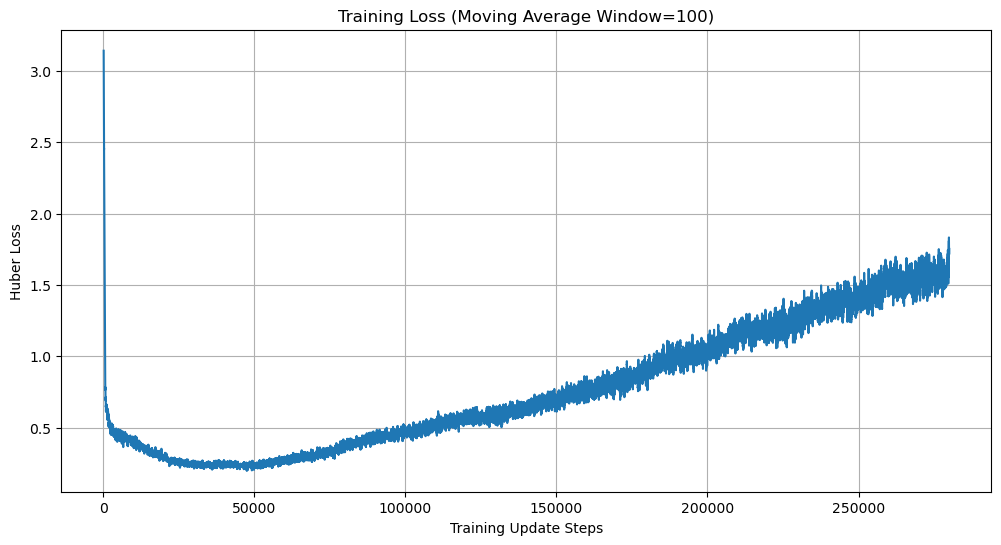

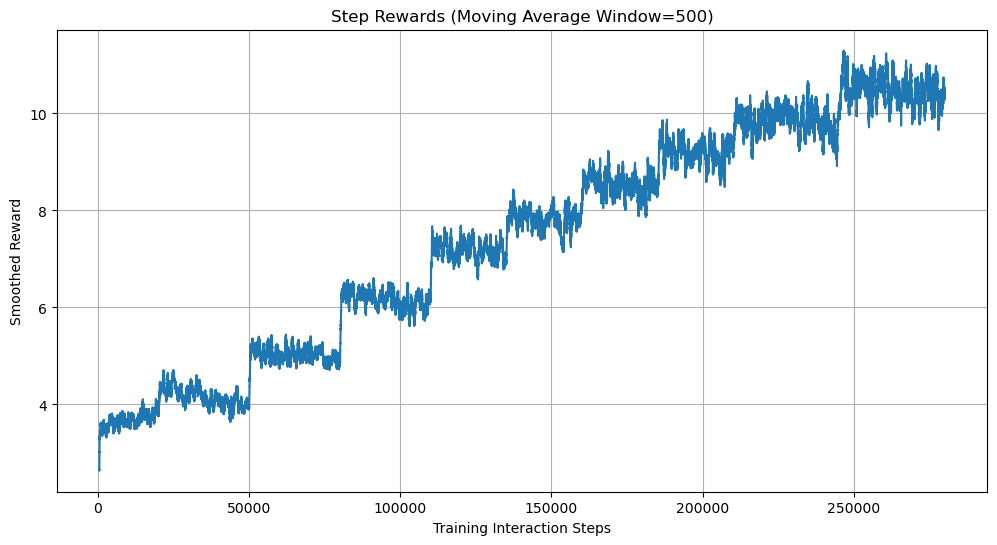

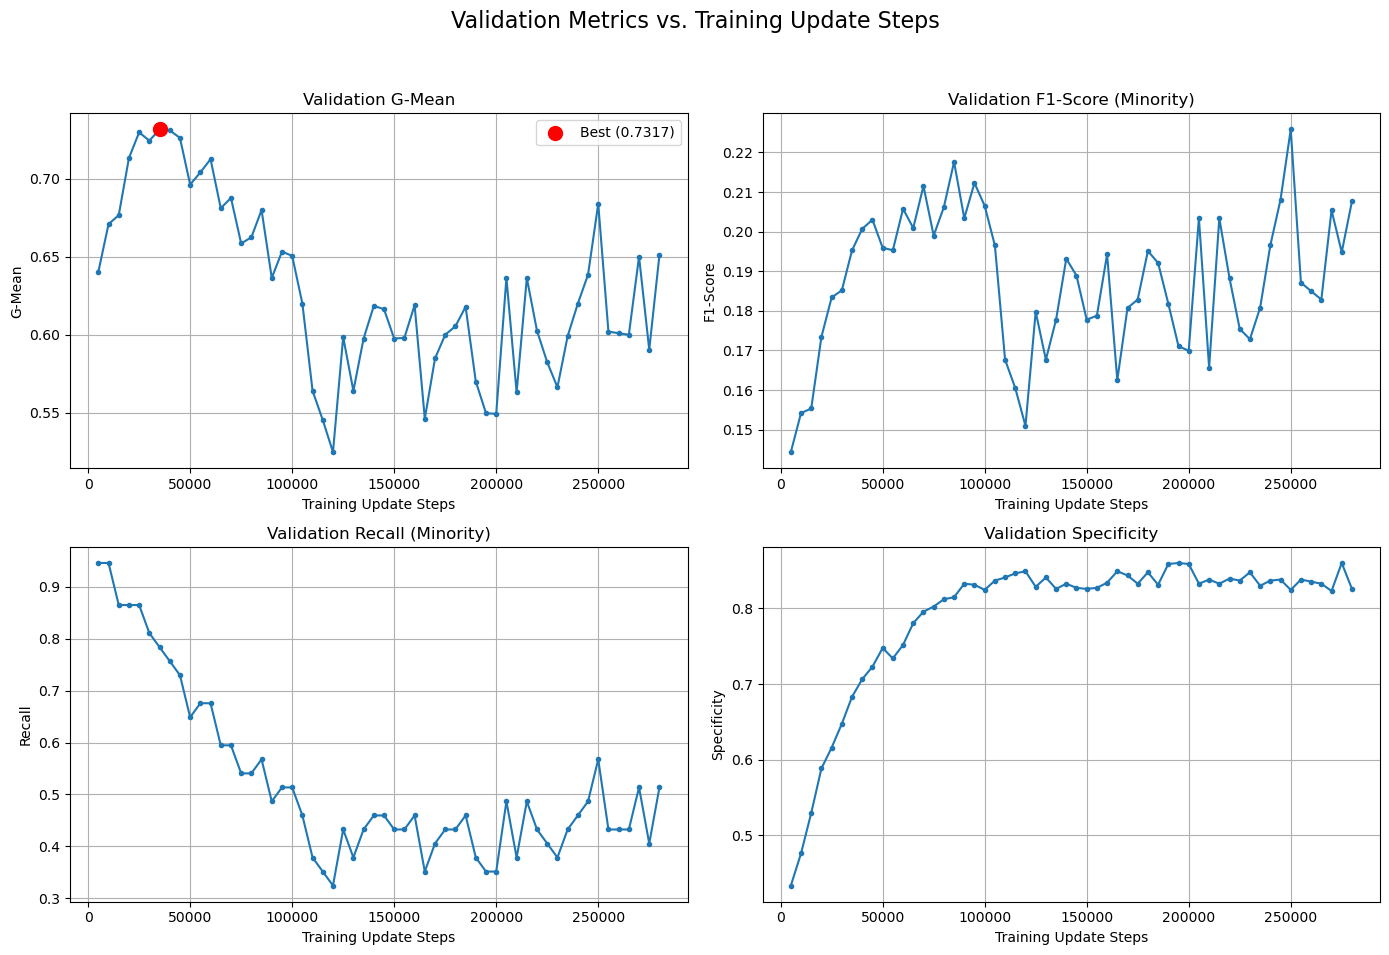


Plotting complete.


In [17]:
print("\n--- Plotting Results ---")
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn for multi-run plots

# Helper function for moving average
def moving_average(data, window_size):
    """ Calculates the moving average of a 1D array. """
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    if data.size < window_size:
        return np.array([])
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Load dataframes if needed (or use lists directly if kernel session is fresh)
try:
    loss_df = pd.read_csv(os.path.join(config.results_save_path, 'step_losses.csv'))
    rewards_df = pd.read_csv(os.path.join(config.results_save_path, 'step_rewards.csv'))
    if os.path.exists(os.path.join(config.results_save_path, 'validation_history.csv')):
        val_history_df = pd.read_csv(os.path.join(config.results_save_path, 'validation_history.csv'))
    else:
        val_history_df = pd.DataFrame() # Create empty if file doesn't exist
    print("Loaded metrics from CSV files.")
except FileNotFoundError:
    print("CSV files not found, using metrics lists from memory (if available).")
    # Use lists directly if they exist in the current session
    loss_df = pd.DataFrame({'step': range(len(step_losses)), 'loss': step_losses}) if step_losses else pd.DataFrame()
    rewards_df = pd.DataFrame({'step': range(len(step_rewards)), 'reward': step_rewards}) if step_rewards else pd.DataFrame()
    val_history_df = pd.DataFrame(validation_history) if validation_history else pd.DataFrame()
except Exception as e:
    print(f"Error loading metric files: {e}. Plotting might fail.")
    loss_df, rewards_df, val_history_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

# 1. Plot Training Loss (Smoothed)
if not loss_df.empty:
    plt.figure(figsize=(12, 6))
    loss_ma_window = min(100, max(1, len(loss_df) // 10))
    smoothed_losses = moving_average(loss_df['loss'].values, loss_ma_window)
    if smoothed_losses.any():
         update_steps_axis = np.arange(loss_ma_window -1, len(loss_df))
         plt.plot(update_steps_axis, smoothed_losses)
         plt.title(f'Training Loss (Moving Average Window={loss_ma_window})')
         plt.xlabel('Training Update Steps')
         plt.ylabel('Huber Loss')
         plt.grid(True)
         plt.show()
    else: print("Not enough loss data for moving average.")
else: print("No loss data found.")

# 2. Plot Step Rewards (Smoothed)
if not rewards_df.empty:
    plt.figure(figsize=(12, 6))
    reward_ma_window = min(500, max(1, len(rewards_df) // 10))
    smoothed_rewards = moving_average(rewards_df['reward'].values, reward_ma_window)
    if smoothed_rewards.any():
        interaction_steps_axis = np.arange(reward_ma_window - 1, len(rewards_df))
        plt.plot(interaction_steps_axis, smoothed_rewards)
        plt.title(f'Step Rewards (Moving Average Window={reward_ma_window})')
        plt.xlabel('Training Interaction Steps')
        plt.ylabel('Smoothed Reward')
        plt.grid(True)
        plt.show()
    else: print("Not enough reward data for moving average.")
else: print("No reward data found.")

# 4. Plot Validation Metrics Over Time
if not val_history_df.empty:
    required_metrics = ['step', 'g_mean', 'f1_score', 'recall', 'specificity']
    if all(metric in val_history_df.columns for metric in required_metrics):
        plt.figure(figsize=(14, 10))
        # ... (Subplot code from previous answer) ...
        plt.subplot(2, 2, 1); plt.plot(val_history_df['step'], val_history_df['g_mean'], marker='.', linestyle='-'); plt.title('Validation G-Mean'); plt.grid(True); plt.ylabel('G-Mean'); plt.xlabel('Training Update Steps')
        if not val_history_df.empty and 'g_mean' in val_history_df.columns: best_gmean_idx = val_history_df['g_mean'].idxmax(); plt.scatter(val_history_df.loc[best_gmean_idx, 'step'], val_history_df.loc[best_gmean_idx, 'g_mean'], color='red', s=100, label=f"Best ({val_history_df.loc[best_gmean_idx, 'g_mean']:.4f})", zorder=5); plt.legend()
        plt.subplot(2, 2, 2); plt.plot(val_history_df['step'], val_history_df['f1_score'], marker='.', linestyle='-'); plt.title('Validation F1-Score (Minority)'); plt.grid(True); plt.ylabel('F1-Score'); plt.xlabel('Training Update Steps')
        plt.subplot(2, 2, 3); plt.plot(val_history_df['step'], val_history_df['recall'], marker='.', linestyle='-'); plt.title('Validation Recall (Minority)'); plt.grid(True); plt.ylabel('Recall'); plt.xlabel('Training Update Steps')
        plt.subplot(2, 2, 4); plt.plot(val_history_df['step'], val_history_df['specificity'], marker='.', linestyle='-'); plt.title('Validation Specificity'); plt.grid(True); plt.ylabel('Specificity'); plt.xlabel('Training Update Steps')
        plt.suptitle('Validation Metrics vs. Training Update Steps', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else: print("Validation history DataFrame is missing required metric columns.")
else: print("No validation history found.")

# Plotting for multiple runs (requires saving/loading results from multiple seeds)
# ... (Add the multi-run plotting code here if you have run the experiment multiple times) ...

print("\nPlotting complete.")